## ***Grafo***

### Import

In [25]:
import json
import random
import networkx as nx
import matplotlib.pyplot as plt

### Definizione della Rete, Seller e Buyer

##### Grafo

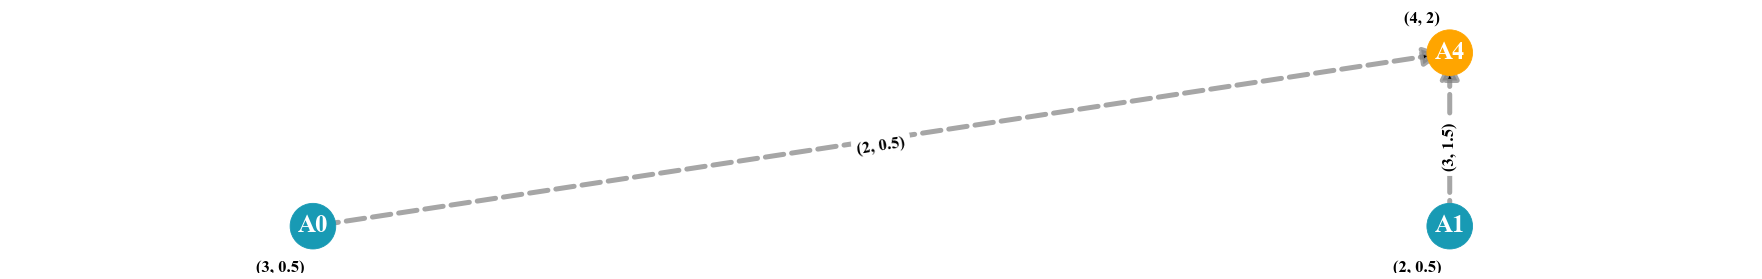

In [26]:
G = nx.DiGraph(); G.graph['Name'] = 'Grafico'; draw = True;  # Variabile per disegnare il grafo

with open('./JSON/Vertex/P1-V.json') as file:
    json_vertex = file.read()

with open('./JSON/Edges/P1-E.json') as file:
    json_edges = file.read()

nodes, edges = [], []; sb = []; seller_groups = 0; # [Num_Seller,Num_Buyer], # Num_Seller_Group
vrt = json.loads(json_vertex); edg = json.loads(json_edges)

for i,item in enumerate(vrt):
    if(i == 0):
        sb = vrt[0]['sb']
        seller_groups = vrt[0]['seller_groups']
    else:
        node_name = item["Node_Name"]
        node_attributes = {
            "Prezzo_Unita": item["Prezzo_Unita"],
            "Disponibilita": item["Disponibilita"],
            "group": item["group"]
        }
        nodes.append((node_name, node_attributes))

for item in edg:
    start_node = item["Start_Node_Name"]
    end_node = item["End_Node_Name"]
    edge_attributes = {
        "capacity": item["capacity"],
        "price": item["price"]
    }
    edges.append((start_node, end_node, edge_attributes))

G.add_nodes_from(nodes); G.add_edges_from(edges); 


if(draw):
    fig = plt.figure(figsize=(30,5), dpi=60); ax = plt.gca(); ax.margins(0.20); plt.tight_layout(); pos = {};
    pos = {node: (2/sb[0]*(i+1),0.75) if i < sb[0] else (2/sb[1]*(i%sb[0]+1),1) for i, node in enumerate(G.nodes)} # Funziona se i buyer sono meno dei seller
    pos_node_label = {p:(pos[p][0]-0.05, pos[p][1]-0.05) if i < sb[0] else (pos[p][0]-0.04,pos[p][1]+0.06) for i,p in enumerate(pos)}
    color = ["#189AB4" for _ in range(sb[0])] + ['orange' for _ in range(sb[1])]; pos_edge_label = {p:(pos[p][0],pos[p][1]-0.01) for p in pos}; 
    
    node_labels={n:(d["Disponibilita"],d["Prezzo_Unita"]) for n,d in G.nodes(data=True)}; edge_labels = {(u,v): (d["capacity"],d["price"]) for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edges(G,pos=pos,width=6,arrowsize=45,alpha=0.7,edge_color="gray",style="dashed") # Draw edges
    nx.draw_networkx_edge_labels(G,pos=pos_edge_label,edge_labels=edge_labels,label_pos=0.5,font_size=20,font_family="Times New Roman", font_weight="bold"); # Draw Edges Labels
    nx.draw_networkx_labels(G,pos=pos_node_label,labels=node_labels,font_color="black",font_size=20,font_family="Times New Roman", font_weight="bold",horizontalalignment='left',verticalalignment='top') # Draw Node Labels
    nx.draw(G,pos=pos,with_labels=True,node_size=3000,node_color=color,font_color="white",font_size=30,font_family="Times New Roman", font_weight="bold",width=0) 

### Aggiunta Archi Indiretti

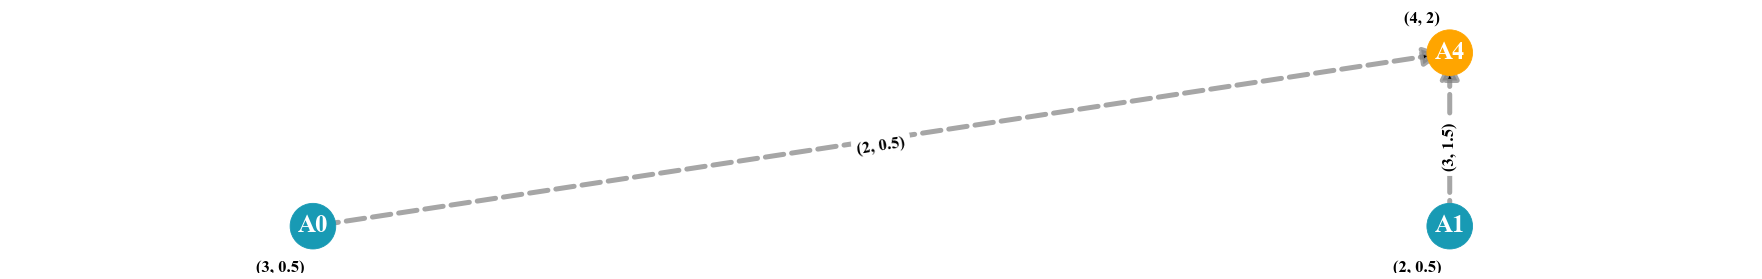

In [27]:
red_edges = [];
for node_start in G.nodes:
    for node_stop in G.nodes:
        if(str(node_start) == str(node_stop).replace("'",'') and "'" in str(node_stop)):
            G.add_edges_from([(str(node_stop),str(node_start),{'capacity':'inf','price':0})])
            red_edges.append((str(node_stop),str(node_start))); #print(node_start,node_stop)

if(draw):
    fig = plt.figure(figsize=(30,5), dpi=60); ax = plt.gca(); ax.margins(0.20); plt.tight_layout();
    edge_labels = {(u,v): (d["capacity"],d["price"]) for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edges(G,pos=pos,width=6,arrowsize=45,alpha=0.7,edge_color="gray",style="dashed") # Draw edges
    nx.draw_networkx_edges(G,pos=pos,width=6,edgelist=red_edges,arrowsize=45,alpha=0.7,edge_color="red",style="dashed") # Draw edges
    nx.draw_networkx_edge_labels(G,pos=pos_edge_label,edge_labels=edge_labels,label_pos=0.5,font_size=20,font_family="Times New Roman", font_weight="bold"); # Draw Edges Labels
    nx.draw_networkx_labels(G,pos=pos_node_label,labels=node_labels,font_color="black",font_size=20,font_family="Times New Roman", font_weight="bold",horizontalalignment='left',verticalalignment='top') # Draw Node Labels
    nx.draw(G,pos=pos,with_labels=True,node_color=color,node_size=3000,font_color="white",font_size=30,font_family="Times New Roman", font_weight="bold",width=0)

## ***Classic Genetic Algorithm***

<div style="margin-bottom: 20px;">
  <table align="center">
    <tr>
      <th></th>
      <th>Problema 1</th>
      <th>Problema 2</th>
      <th>Problema 3</th>
    </tr>
    <tr>
      <th>Tempo di Esecuzione (s)</th>  
      <td align="center">0.03</td>
      <td align="center">0.04</td>
      <td align="center">0.09</td>
    </tr>
    <tr>
      <th>% Corrette</th>
      <td align="center">100%</td>
      <td align="center">100%</td>
      <td align="center">20%</td>
    </tr>
  </table>
</div>


<center>Table 1: Risoluzione con gli Algoritmi Genetici Classici</center>

### Import

In [28]:
import random
import numpy as np
from Codice.Colors import clr
from deap import base, creator, tools

### Estrazione delle informazioni dal Grafo

In [29]:
nodes, costi, cap_seller, cap_buyer, cap_transp = list(G.nodes), [], [], [], []
var_cap_seller = np.zeros((sb[0],sb[0],sb[1])); cap_seller = np.zeros((sb[0]));
var_cap_buyer = np.zeros((sb[1],sb[0],sb[1])); cap_buyer = np.zeros((sb[1]));
var_cap_tran = np.empty((0, sb[0]*sb[1])); cap_tran = np.empty((0,))
not_edges = np.zeros(sb[0]*sb[1]);


# Calcolo dei Costi
for i in range(sb[0]):
    for j in range(sb[0],sb[0]+sb[1]):
        if(G.has_edge(nodes[i],nodes[j])): costi.append(round(G[nodes[i]][nodes[j]]['price'] + G.nodes[nodes[i]]['Prezzo_Unita'],2))
        else: costi.append(10e3)

# Vincoli Disponibilità Seller
for i in range(sb[0]):
    for out_edge in G.out_edges(list(G.nodes())[i]):
        if("'" not in str(out_edge[0])): var_cap_seller[i,list(G.nodes()).index(out_edge[0])%sb[0],list(G.nodes()).index(out_edge[1])%sb[0]] = 1
        else: var_cap_seller[i,list(G.nodes()).index(out_edge[1])%sb[0],list(G.nodes()).index(out_edge[0])%sb[0]] = 1
    for in_edge in G.in_edges(list(G.nodes())[i]):
        if("'" not in str(in_edge[0])): var_cap_seller[i,list(G.nodes()).index(in_edge[0])%sb[0],list(G.nodes()).index(in_edge[1])%sb[0]]
        else: var_cap_seller[list(G.nodes()).index(in_edge[1])%sb[0],list(G.nodes()).index(in_edge[0])%sb[0]]
    cap_seller[i] = G.nodes[list(G.nodes())[i]]['Disponibilita']


# # Vincoli Richieste Buyer
for j in range(sb[1]):
    for out_edge in G.out_edges(list(G.nodes())[sb[0]+j]):
        if("'" not in str(out_edge[0])): var_cap_buyer[j,list(G.nodes()).index(out_edge[0])%sb[0],list(G.nodes()).index(out_edge[1])%sb[0]] = -1
        else: var_cap_buyer[j,list(G.nodes()).index(out_edge[1])%sb[0],list(G.nodes()).index(out_edge[0])%sb[0]] = -1
    for in_edge in G.in_edges(list(G.nodes())[sb[0]+j]):
        if("'" not in str(in_edge[0])): var_cap_buyer[j,list(G.nodes()).index(in_edge[0])%sb[0],list(G.nodes()).index(in_edge[1])%sb[0]] = -1
        else: var_cap_buyer[j,list(G.nodes()).index(in_edge[1])%sb[0],list(G.nodes()).index(in_edge[0])%sb[0]] = -1
    cap_buyer[j] = -G.nodes[list(G.nodes())[sb[0]+j]]['Disponibilita']

# Vincoli Capacità Archi
for i in range(seller_groups):
    nodes = [node for node in G.nodes if G.nodes[node]['group'] == i and "'" not in str(node)]
    for j in range(sb[1]):
        if G.has_edge(nodes[0],list(G.nodes())[sb[0]+j]):
            vv = np.zeros((sb[0]*sb[1])) 
            for node in nodes:
                if G.has_edge(node,list(G.nodes())[sb[0]+j]):
                    vv[sb[1]*list(G.nodes()).index(node)+list(G.nodes()).index(list(G.nodes())[sb[0]+j])%sb[0]] = 1 
            var_cap_tran = np.vstack((var_cap_tran, vv))
            cap_tran = np.append(cap_tran, G[nodes[0]][list(G.nodes())[sb[0]+j]]['capacity'])

# Vincoli Archi Inesistenti
for s in range(sb[0]):
    for b in range(sb[1]):
        if G.has_edge(list(G.nodes())[s],list(G.nodes())[sb[0]+b]) or str(list(G.nodes())[s]) == str(list(G.nodes())[sb[0]+b]).replace("'",''): not_edges[sb[1]*s+b] = 0
        else: not_edges[sb[1]*s+b] = 1


def check_constraint(point): return (np.dot(var_cap_seller.reshape((sb[0],sb[0]*sb[1])),point) <= cap_seller).all() and \
                                    (np.dot(var_cap_buyer.reshape((sb[1],sb[0]*sb[1])),point) == cap_buyer).all() and \
                                    (np.dot(var_cap_tran,point) <= cap_tran).all() and \
                                    (np.dot(not_edges,point) <= 0).all()

### Definizione degli Elementi

In [30]:
def fitness(individual): return np.dot(costi,individual),

def feasible(individual): return check_constraint(individual)

def evaluate_and_remove_invalid(individual):
    global counter, best, best_count
    counter += 1
    if feasible(individual): 
        cost = fitness(individual)
        if(cost[0] < best): best = cost[0]; best_count = counter
        return cost
    else: return (fitness(individual)[0]+1e6,) # return a very high penalty if the solution is not feasible

### Algoritmo Genetico Classico

In [31]:
for i in range(10):
    global counter, best, best_count; counter = 0; best = 10e10; best_count = 0; upper = 3 # Set the random seed to a fixed value # Fissare il SEED per entrambi e valutarlo per diversi SEED.
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,)); creator.create("Individual", list, fitness=creator.FitnessMin);
    toolbox = base.Toolbox(); toolbox.register("attr_bool", random.randint,0,upper) # Rappresenta i valori che il singolo allele può assumere in questo caso è interi tra [0 o 100]
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool,n=sb[0]*sb[1]) # Structure initializers, ogni individuo ha 2 alleli
    toolbox.register("population", tools.initRepeat, list, toolbox.individual) # Definisce la popolazione

    toolbox.register("evaluate", evaluate_and_remove_invalid); toolbox.register("mate", tools.cxOnePoint) #toolbox.register("mate", tools.cxTwoPoint) # crossover
    toolbox.register('selBest',tools.selBest); toolbox.register("mutate", tools.mutUniformInt,low=0,up=upper,indpb=0.2) # mutation
    toolbox.register("select", tools.selTournament, tournsize=3)  # selection

    # computing statistics
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register('max', np.max); stats.register('min', np.min); stats.register('avg', np.mean); stats.register('std', np.std)
    logbook = tools.Logbook() # logging data

    # the hall of fame contains the best individual that ever lived in the population during the evolution
    hof = tools.HallOfFame(maxsize=3)

    CXPB = 0.8; MUTPB = 0.9; max_fit = 402; NPOP = 3; best_ind = None; 
    pop = toolbox.population(n=NPOP); fitnesses = list(map(toolbox.evaluate,pop)); 
    for ind, fit in zip(pop,fitnesses): ind.fitness.values = fit

    # Begin the evolution
    while counter < max_fit:

        best_current = toolbox.clone(toolbox.selBest(pop,k=1)[0]); best_cost = best_current.fitness.values[0]; 
        if best_ind is None or best_current.fitness > best_ind.fitness: best_ind = toolbox.clone(best_current)

        offspring = toolbox.select(pop, len(pop)) # Select the next generation individuals
        offspring = list(map(toolbox.clone, offspring)) # Clone the selected individuals

        for child1, child2 in zip(offspring[::2], offspring[1::2]): # Apply crossover and mutation on the offspring
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        pop[:] = toolbox.selBest(offspring,k=(NPOP-1)); pop.append(best_ind); hof.update(pop);
        
    print(f"Solutions: {hof[0]} with fitness {hof[0].fitness.values[0]}")
    print(f"The best fitness value: {best}") 
    print(f"The fitness evaluations to obtain the best: {best_count}") 
    print(f"Number of fitness evaluations: {counter}\n\n")

c:\Python310\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Python310\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Solutions: [0, 0] with fitness 1000000.0
The best fitness value: 100000000000.0
The fitness evaluations to obtain the best: 0
Number of fitness evaluations: 404


Solutions: [0, 0] with fitness 1000000.0
The best fitness value: 100000000000.0
The fitness evaluations to obtain the best: 0
Number of fitness evaluations: 402


Solutions: [0, 0] with fitness 1000000.0
The best fitness value: 100000000000.0
The fitness evaluations to obtain the best: 0
Number of fitness evaluations: 404


Solutions: [0, 0] with fitness 1000000.0
The best fitness value: 100000000000.0
The fitness evaluations to obtain the best: 0
Number of fitness evaluations: 404


Solutions: [2, 2] with fitness 6.0
The best fitness value: 6.0
The fitness evaluations to obtain the best: 134
Number of fitness evaluations: 404


Solutions: [2, 2] with fitness 6.0
The best fitness value: 6.0
The fitness evaluations to obtain the best: 188
Number of fitness evaluations: 402


Solutions: [0, 0] with fitness 1000000.0
The best fi